In [1]:
!pip install -q tensorflow==2.1.0
!pip install -q tensorflow-quantum
!pip install qiskit
!pip install cirq

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 450kB 42.4MB/s 
     |████████████████████████████████| 3.9MB 47.1MB/s 
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
     |████████████████████████████████| 3.9MB 2.9MB/s 
     |████████████████████████████████| 5.3MB 22.5MB/s 
     |████████████████████████████████| 163kB 49.1MB/s 
     |████████████████████████████████| 1.4MB 47.1MB/s 
     |████████████████████████████████| 112kB 44.2MB/s 
     |████████████████████████████████| 133kB 42.0MB/s 
     |████████████████████████████████| 1.2MB 48.2MB/s 
     |████████████████████████████████| 6.7MB 2.7MB/s 
     |████████████████████████████████| 23.3MB 70.5MB/s 
     |████████████████████████████████| 163kB 42.1MB/s 
     |████████████████████████████████| 184kB 48.0MB/s 
     |████████████████████████████████| 1.9MB 37.5MB/s 
     |████████████████████████████████| 768kB

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

import seaborn as sns
import collections


from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit import Aer
from qiskit.compiler import transpile
import numpy as np
from math import sin, cos, atan2
import matplotlib.pyplot as plt
from numpy.linalg import norm,svd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Classical Data Preparation

In [8]:
from google.colab import drive
drive.mount('/content/drive')
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Output_data_ML.npy')

X=X.astype(np.float64)
Y=Y.astype(np.float64)

print(np.shape(X),np.shape(Y))
X.dtype, Y.dtype

'''
X = np.load('Input_data_ML.npy')
Y = np.load('Output_data_ML.npy')
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1070107, 38) (15, 1070107)


"\nX = np.load('Input_data_ML.npy')\nY = np.load('Output_data_ML.npy')\n"

In [9]:
pca=PCA(n_components=16)
X=pca.fit_transform(X)

scaler2 =StandardScaler()
X=scaler2.fit_transform(X)

In [10]:
Y=Y.T
Y[:,6:]=Y[:,6:]%(2*np.pi)

'''
y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std/4 

key=np.all(np.abs(Y)<1,axis=1) #keeping values only in 4 sigma
Y=Y[key,:]
X=X[key,:]

'''
y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std
print(np.mean(Y,axis=0),np.std(Y,axis=0))

R=np.array([i for i in range(Y.shape[0])])
np.random.shuffle(R)
X=X[R,:]
Y=Y[R,:]  

Q1=np.quantile(Y,0.10,axis=0)
Q3=np.quantile(Y,0.90,axis=0)
IQR=Q3-Q1
X=X[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]
Y=Y[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

print(np.mean(Y,axis=0),np.std(Y,axis=0))


[-2.98008584e-16 -1.73137660e-14  7.44801459e-15 -4.03670206e-15
 -1.53793019e-14 -1.91102771e-14 -9.74052969e-12  7.40719433e-11
 -1.25475981e-10 -1.26059721e-10 -1.27361924e-10  1.42486661e-10
 -6.48805895e-13 -9.40183639e-12  8.49653711e-14] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(818880, 16) (818880, 15) (204720, 16) (204720, 15)
[ 0.00367391  0.00301703  0.00192874  0.00272646  0.00344894  0.00312251
 -0.02518176  0.01479297 -0.0200592  -0.02218453 -0.00711926  0.00922037
  0.15577354 -0.14126018  0.10889032] [0.21967639 0.22145078 0.23628999 0.21217199 0.21382921 0.18725208
 0.99315809 0.98468965 0.99251663 0.99288506 0.99478313 1.00079107
 0.29176488 0.29879649 0.27264246]


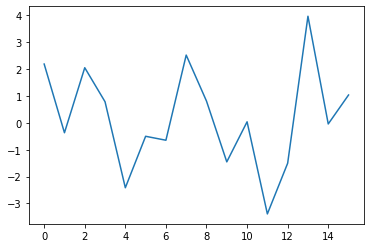

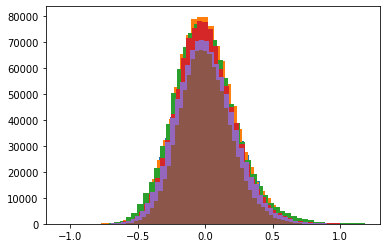

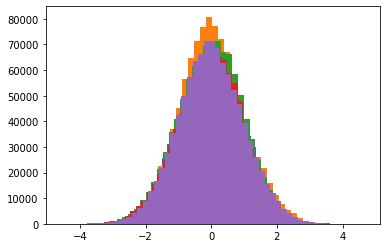

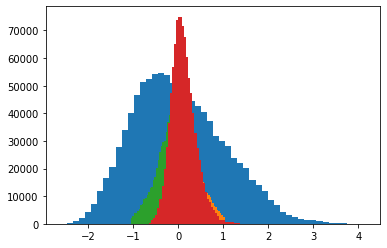

In [11]:
plt.plot(X[10000,:])
plt.show()
for i in range(6):
  plt.hist(Y[:,i],bins=50)
plt.show()
for i in range(6,11):
  plt.hist(Y[:,i],bins=50)
plt.show()
for i in range(11,15):
  plt.hist(Y[:,i],bins=50)
plt.show()

## Quantum Data Preparation

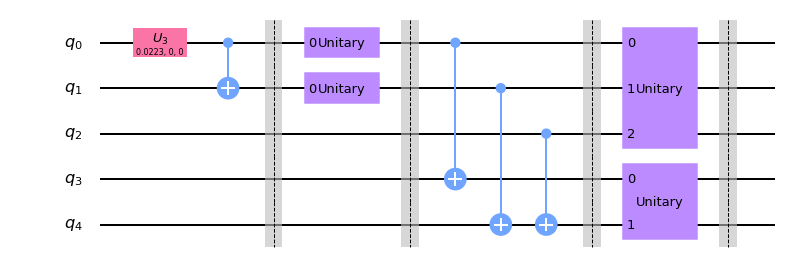

In [12]:
def state_prep(ckt,A,q):
    A=A/np.linalg.norm(A)
    
    if q==1:
        ckt.u3(2*atan2(A[1],A[0]),0,0,0)
        return ckt
    
    n=q-q//2 #n>=m
    m=q//2
    A=np.reshape(A,(2**m,2**n))
    A=np.transpose(A)
    
    U,S,V=np.linalg.svd(A)
    ckt=state_prep(ckt,S,q//2)
    
    for i in range(m):
        ckt.cx(i,i+n)
    if q%2==1:
        ckt.cx(q//2,q-1)
    ckt.barrier()
    
    ckt.unitary(Operator(U), list(range(n)))
    ckt.unitary(Operator(np.transpose(V)), list(range(n,q)))
    ckt.barrier()
    return ckt

q=5
A=np.random.rand(2**q)

qiskit_ckt=QuantumCircuit(q)
qiskit_ckt=state_prep(qiskit_ckt,A,q)
qiskit_ckt.draw(output='mpl')

In [13]:
qiskit_ckt=transpile(qiskit_ckt,basis_gates=['cx','u3'])
#qiskit_ckt.draw(output='mpl')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


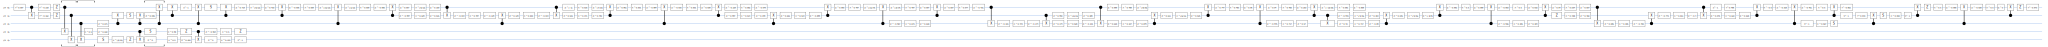

In [14]:
def qiskit_to_cirq(qiskit_ckt,q):
    cirq_ckt=cirq.Circuit()
    cirq_qubits=cirq.GridQubit.rect(1,q)

    for data in qiskit_ckt.data:
        if data[0].name=='u3':
            theta, phi, lambd = data[0]._params
            matrix=np.array([[np.cos(theta/2),-np.exp(1j*lambd)*np.sin(theta/2)],[np.exp(1j*phi)*np.sin(theta/2),np.exp(1j*(phi+lambd))*np.cos(theta/2)]])
            #print(np.array(matrix).round(3))

            synthesized_operations = cirq.single_qubit_matrix_to_gates(matrix)
            for opr in synthesized_operations:
                cirq_ckt.append(opr(cirq_qubits[data[1][0].index]))

        elif data[0].name=='cx':
            cirq_ckt.append(cirq.CNOT(cirq_qubits[data[1][0].index],cirq_qubits[data[1][1].index]))
    return cirq_ckt

cirq_qubits=cirq.GridQubit.rect(1,q)
cirq_ckt=qiskit_to_cirq(qiskit_ckt,q)
SVGCircuit(cirq_ckt)

In [15]:
def Quantum_Data(A,q):
    qiskit_ckt=QuantumCircuit(q)
    qiskit_ckt=state_prep(qiskit_ckt,A,q)
    for i in range(q//2):
        qiskit_ckt.swap(i,q-i-1)
    qiskit_ckt=transpile(qiskit_ckt,basis_gates=['cx','u3'])
    cirq_ckt=qiskit_to_cirq(qiskit_ckt,q)
    return cirq_ckt

#### Testing on Random Input

In [16]:
'''#X_expand=X_expand[:100]
#Y_expand=Y_expand[:100]

q=3

X=np.random.rand(1000,2**q)
X_expand=X/np.reshape(np.linalg.norm(X,axis=1),(-1,1))

Y_expand=np.abs(np.fft.fft(X_expand,axis=1)/np.sqrt(2**q))**2

xtrain, xtest, ytrain, ytest = train_test_split(X_expand, Y_expand, test_size=0.2)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

t=time.time()
xtrain=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtrain])
xtest=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtest])
print(time.time()-t)
'''

'#X_expand=X_expand[:100]\n#Y_expand=Y_expand[:100]\n\nq=3\n\nX=np.random.rand(1000,2**q)\nX_expand=X/np.reshape(np.linalg.norm(X,axis=1),(-1,1))\n\nY_expand=np.abs(np.fft.fft(X_expand,axis=1)/np.sqrt(2**q))**2\n\nxtrain, xtest, ytrain, ytest = train_test_split(X_expand, Y_expand, test_size=0.2)\nprint(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))\n\nt=time.time()\nxtrain=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtrain])\nxtest=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtest])\nprint(time.time()-t)\n'

#### Working with a small dataset 

In [17]:
m=np.shape(X)[0]
key=np.random.randint(m,size=1000)

X_small=X[key]
Y_small=Y[key]

q=4

xtrain, xtest, ytrain, ytest = train_test_split(X_small, Y_small, test_size=0.2)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

t=time.time()
xtrain=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtrain])
xtest=tfq.convert_to_tensor([Quantum_Data(x,q) for x in xtest])
print(time.time()-t)

(800, 16) (800, 15) (200, 16) (200, 15)
23.894965648651123


## Quantum Neural Network

In [18]:
#TFQ State Layer
'''q0, q1 = cirq.GridQubit.rect(1, 2)
alpha = sympy.Symbol('alpha') # degree of entanglement between q0, q1
parametrized_bell_circuit = cirq.Circuit(
   cirq.H(q0), cirq.CNOT(q0, q1) ** alpha)

state_layer = tfq.layers.State()
alphas = tf.reshape(tf.convert_to_tensor(1),(1,1))
output=state_layer(parametrized_bell_circuit, symbol_names=[alpha], symbol_values=alphas)
print(output)
tf.reduce_mean(tf.abs(output),axis=0)'''

"q0, q1 = cirq.GridQubit.rect(1, 2)\nalpha = sympy.Symbol('alpha') # degree of entanglement between q0, q1\nparametrized_bell_circuit = cirq.Circuit(\n   cirq.H(q0), cirq.CNOT(q0, q1) ** alpha)\n\nstate_layer = tfq.layers.State()\nalphas = tf.reshape(tf.convert_to_tensor(1),(1,1))\noutput=state_layer(parametrized_bell_circuit, symbol_names=[alpha], symbol_values=alphas)\nprint(output)\ntf.reduce_mean(tf.abs(output),axis=0)"

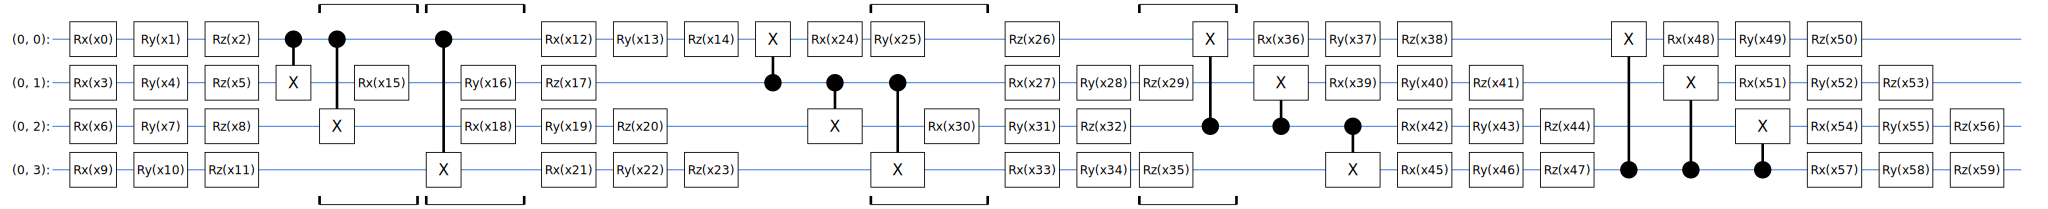

In [19]:
def n_qubit_unitary_gate(n):
    circuit=cirq.Circuit()
    qubits=cirq.GridQubit.rect(1,n)
    x=sympy.symbols('x0:'+str(3*n*(n+1)))
    
    for i in range(n):
        for j in range(n):
            circuit.append(cirq.rx(x[3*n*i+3*j])(qubits[j]))
            circuit.append(cirq.ry(x[3*n*i+3*j+1])(qubits[j]))
            circuit.append(cirq.rz(x[3*n*i+3*j+2])(qubits[j]))
        for j in range(n):
            if i==j: continue
            circuit.append(cirq.CNOT(qubits[i],qubits[j]))
    for j in range(n):
        circuit.append(cirq.rx(x[3*n**2+3*j])(qubits[j]))
        circuit.append(cirq.ry(x[3*n**2+3*j+1])(qubits[j]))
        circuit.append(cirq.rz(x[3*n**2+3*j+2])(qubits[j]))
    return circuit
    
SVGCircuit(n_qubit_unitary_gate(q))

## Readout Operators

In [20]:
def readout_ancilliary(p,q):
    new_p=[]
    for key in p:
        new_p.append(key * 0.5 * (1 + cirq.Z(q)))
    for key in p:
        new_p.append(key * 0.5 * (-cirq.Z(q)+ 1))
    return new_p

In [21]:
def readout(q_out):
    qubits = cirq.GridQubit.rect(1, q_out)

    p0=0.5 * (1 + cirq.Z(qubits[0]))
    p1=0.5 * (-cirq.Z(qubits[0])+ 1)

    read=[p0,p1]

    for i in range(1,q_out):
        read=readout_ancilliary(read,qubits[i])
    return read

def readout2(q_out):
    qubits = cirq.GridQubit.rect(1, q)

    p0=0.5 * (1 + cirq.Z(qubits[q-q_out]))
    p1=0.5 * (-cirq.Z(qubits[q-q_out])+ 1)

    read=[p0,p1]

    for i in range(1,q_out):
        read=readout_ancilliary(read,qubits[i+q-q_out])
    return read

def small_readout(n):
    qubits = cirq.GridQubit.rect(1,n)
    return 0.5 * (1 + cirq.Z(qubits[n-1]))

[-0.42010686  0.1320936   0.18264718 -0.36662787 -0.00387741  0.16288973
 -0.19503315  0.22993802 -0.05012315  0.12286919  0.06064228 -0.18579021
  0.01831132  0.11977521 -0.01436389]


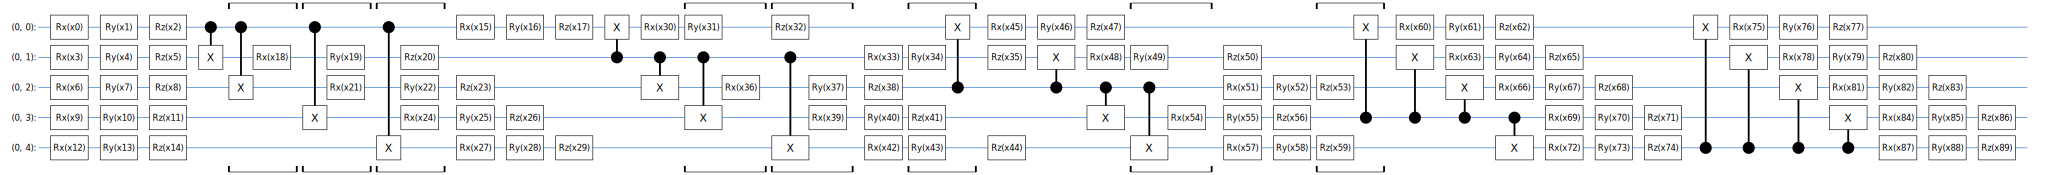

In [22]:
#Testing PQC Readout.
res=[]
for i in range(15):
  circuit=n_qubit_unitary_gate(q+1)
  qubits = cirq.GridQubit.rect(1,q+1)

  outputs = tfq.layers.PQC(circuit, cirq.Z(qubits[q]))
  quantum_data = tfq.convert_to_tensor([cirq.Circuit()])
  res.append(outputs(quantum_data))
  
print(np.reshape(res,-1))

SVGCircuit(circuit)

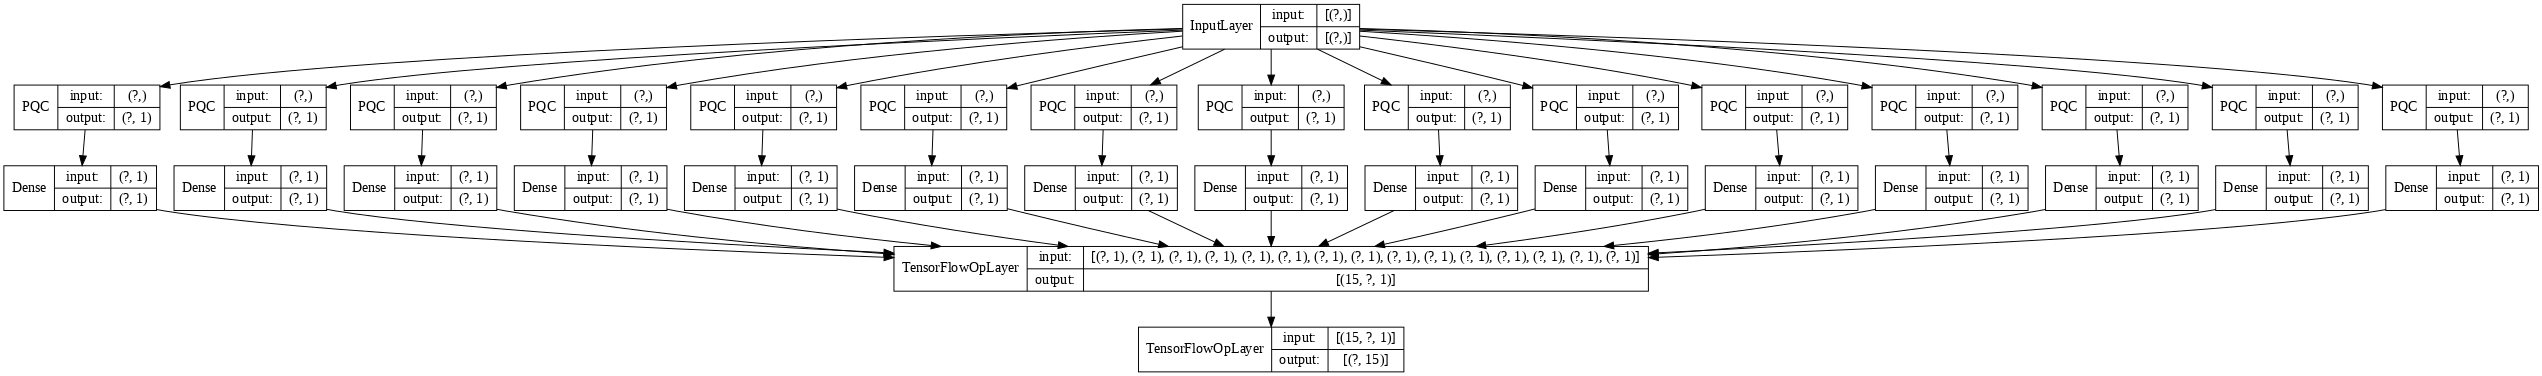

In [23]:
encoded_input=tf.keras.Input(shape=(), dtype=tf.dtypes.string)

output=[]
for i in range(15):
  x = tfq.layers.PQC(n_qubit_unitary_gate(q+1), cirq.Z(qubits[q]))(encoded_input)
  x=tf.keras.layers.Dense(1,activation='linear')(x) #Assist in Scaling
  output.append(x)
output=tf.reshape(output,(-1,15))

model = tf.keras.Model(inputs=[encoded_input], outputs=output)

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=70)

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                   loss=tf.losses.mse)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
pqc_15 (PQC)                    (None, 1)            90          input_1[0][0]                    
__________________________________________________________________________________________________
pqc_16 (PQC)                    (None, 1)            90          input_1[0][0]                    
__________________________________________________________________________________________________
pqc_17 (PQC)                    (None, 1)            90          input_1[0][0]                    
______________________________________________________________________________________________

In [25]:
history = model.fit(x=xtrain,
                    y=ytrain,
                    batch_size=16,
                    epochs=10,
                    verbose=1,
                    validation_data=(xtest, ytest))

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 1032s 1s/sample - loss: 0.4547 - val_loss: 0.4289
Epoch 2/10
800/800 [==============================] - 1033s 1s/sample - loss: 0.4396 - val_loss: 0.4234
Epoch 3/10
800/800 [==============================] - 1027s 1s/sample - loss: 0.4368 - val_loss: 0.4172
Epoch 4/10
800/800 [==============================] - 1023s 1s/sample - loss: 0.4352 - val_loss: 0.4176
Epoch 5/10
800/800 [==============================] - 1024s 1s/sample - loss: 0.4337 - val_loss: 0.4168
Epoch 6/10
800/800 [==============================] - 1025s 1s/sample - loss: 0.4340 - val_loss: 0.4160
Epoch 7/10
800/800 [==============================] - 1025s 1s/sample - loss: 0.4329 - val_loss: 0.4173
Epoch 8/10
800/800 [==============================] - 1026s 1s/sample - loss: 0.4331 - val_loss: 0.4165
Epoch 9/10
800/800 [==============================] - 1033s 1s/sample - loss: 0.4333 - val_loss: 0.4149
Epoch 10/10
800/80

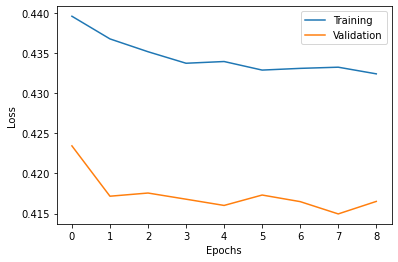

In [26]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
y_hat=model.predict(xtest)

In [32]:
np.shape(y_hat)

(200, 15)

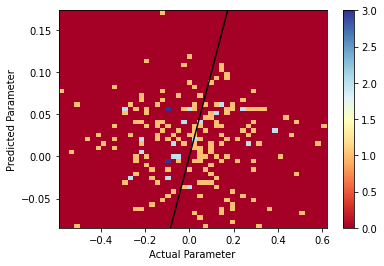

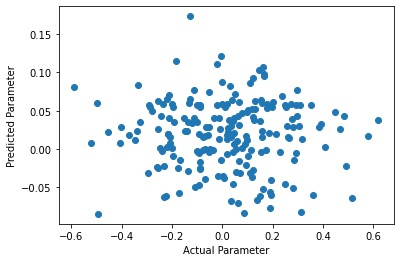

In [34]:
from matplotlib import cm

plt.hist2d(ytest[:,0],y_hat[:,0],bins=50,cmap=cm.RdYlBu) #,range=[[0,0.12],[0,0.12]])
plt.xlabel('Actual Parameter')
plt.ylabel('Predicted Parameter')
plt.colorbar()
plt.plot(np.arange(-1,1,0.01),np.arange(-1,1,0.01),c='k')
plt.show()

plt.scatter(ytest[:,0],y_hat[:,0]) 
plt.xlabel('Actual Parameter')
plt.ylabel('Predicted Parameter')
plt.show()

[-0.057, -0.082, -0.067, -0.036, -0.086, -0.085, -0.016, 0.003, 0.001, 0.007, -0.006, -0.007, -0.417, -0.438, -0.123]


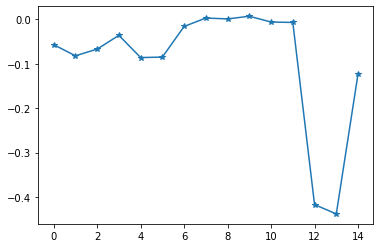

In [36]:
R2=[]
from sklearn.metrics import r2_score 
for i in range(15):
  R2.append(np.round(r2_score(ytest[:,i], y_hat[:,i]),3))
print(R2)
plt.plot(R2,marker='*')

$R^2$ values: \\
6-qubit Unitart Gate: 0.2 \\
7-qubit Unitart Gate: 0.249


In [ ]:
#1. Run Time Analysis
#2. Compare PQC using PauliSum against Expectation Layer  (Should be the same)
#PennyLane is Best